# Load Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import io
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
import os, json, math
from lifelines import KaplanMeierFitter
from typing import List, Dict, Tuple, Optional, Union, Any, Iterable

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_pdf import FigureCanvasPdf
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

# Generate Synthetic Data

In [3]:
def simulate_true_ipd(n: int,
                      dist: str = "weibull",
                      shape: float = 1.5,   # Weibull k
                      scale: float = 8.0,   # Weibull lambda
                      c_max: float = 12.0,
                      random_state: int = 0) -> pd.DataFrame:
    """
    Simulate ground truth:
    Event times T: from a distribution (Weibull/Exponential)
    Censor time: independent Uniform (0, c_max)
    More/less censoring: change c_max
    Increasing/decreasing hazards: change shape (Weibull k)
    Heavier tails/faster failures: change scale
    
    """
    rng = np.random.default_rng(random_state)
    if dist.lower() == "weibull":
        T = scale * rng.weibull(shape, size=n)
    elif dist.lower() == "exponential":
        T = rng.exponential(scale=scale, size=n)
    else:
        raise ValueError("dist must be 'weibull' or 'exponential'") # more distirbution types?
    C = rng.uniform(0.0, c_max, size=n) # indepdenent censoring - adjust
    X = np.minimum(T, C) # observed time
    E = (T <= C).astype(int) # event indicator
    return pd.DataFrame({"time": X, "event": E})

def km_drop_points(times: np.ndarray, events: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Converts the perfect subject-level data (IPD) into the coordinates of the perfect, ideal Kaplan-Meier curve.
    Fit a KM fitter to the IPD
    Return (t,S) at bottoms of KM drops (event times; survival after the drop). This represents the curve for digitzation
    
    """
    kmf = KaplanMeierFitter().fit(times, event_observed=events)
    et = kmf.event_table.reset_index()
    drop_rows = et[et["observed"] > 0].copy()
    S_series = kmf.survival_function_.reindex(drop_rows["event_at"]).iloc[:, 0]
    t = drop_rows["event_at"].to_numpy(dtype=float)
    S = S_series.to_numpy(dtype=float)
    mask = t > 0  # drop any t=0
    return t[mask], S[mask]

def generate_risk_table(df: pd.DataFrame, n_interval: int) -> pd.DataFrame:
    """
    Generate a risk table showing number at risk at regular time intervals.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'time' and 'event' (1=event, 0=censor)
    n_interval : int
        Number of intervals between 0 and ceil(max(time))

    Returns
    -------
    pd.DataFrame
        Columns: ['time', 'n_at_risk'], both integers
    """
    # Sort by time
    df = df.sort_values('time').reset_index(drop=True)

    # Define interval cut points
    max_time = np.ceil(df['time'].max())
    interval = np.ceil(max_time / n_interval).astype(int)
    time_points = np.arange(0, (n_interval + 1) * interval, interval)

    # Compute number at risk at each interval start
    n_total = len(df)
    n_at_risk = []

    for t in time_points:
        n_alive = np.sum(df['time'] >= t)
        n_at_risk.append(int(n_alive))

    risk_table = pd.DataFrame({
        'time': time_points,
        'n_at_risk': n_at_risk
    })

    return risk_table

## Simulate IPD

In [7]:
n = 100
n_rep_censor = 20
n_rep_event = 20
c_max = 30
seed = 2
true_ipd = simulate_true_ipd(n, dist="weibull", shape=1.4, scale=10.0, c_max=c_max, random_state=seed)

# Insert duplicated censor points to ensure they are at the end of the same time as events
censored_ipd = true_ipd[true_ipd['event'] == 0].reset_index(drop=True).copy().sort_values('time').reset_index(drop=True)
replicated_censors = censored_ipd.sample(n=n_rep_censor, replace=True, random_state=seed)
true_ipd = pd.concat([true_ipd, replicated_censors], ignore_index=True).sort_values('time').reset_index(drop=True)

# Insert duplicated event points to ensure they are at the end of the same time as events
event_ipd = true_ipd[true_ipd['event'] == 1].reset_index(drop=True).copy().sort_values('time').reset_index(drop=True)
replicated_event = event_ipd.sample(n=n_rep_event, replace=True, random_state=seed)
true_ipd = pd.concat([true_ipd, replicated_event], ignore_index=True).sort_values('time').reset_index(drop=True)

# Generate Risk Table
risk_df = generate_risk_table(true_ipd, n_interval=8)

## Generate PDF

In [16]:
# ---- Kaplan–Meier estimator (manual) ----
def km_estimator(times, events):
    """
    Compute Kaplan–Meier step function.
    Parameters
    ----------
    times : array-like of shape (n,)
        Observed times (min(T, C)).
    events : array-like of {0,1}
        1 if event observed, 0 if censored.
    Returns
    -------
    t_steps : np.ndarray
        Time points at which survival changes (including 0).
    s_steps : np.ndarray
        Survival probabilities corresponding to t_steps.
    s_at_times : dict
        Mapping from unique times to survival right after time (useful for markers).
    risk_table : pd.DataFrame
        Table with columns ['time','n_risk','n_event','n_censor','survival'].
    """
    df = pd.DataFrame({"time": np.asarray(times, dtype=float), "event": np.asarray(events, dtype=int)})
    # Sort by time, count events and censorings at each unique time
    grouped = df.groupby("time").agg(n_event=("event", "sum"), n_total=("event", "size"))
    grouped["n_censor"] = grouped["n_total"] - grouped["n_event"]
    # Number at risk just before each time
    # Initialize at N and subtract totals cumulatively (shifted)
    N = len(df)
    n_total_cum = grouped["n_total"].cumsum().shift(fill_value=0)
    grouped["n_risk"] = N - n_total_cum
    # KM product
    surv = []
    prod = 1.0
    s_at_times = {}
    for t, row in grouped.iterrows():
        d = row["n_event"]
        n = row["n_risk"]
        if n > 0:
            prod = prod * (1.0 - d / n)
        surv.append(prod)
        s_at_times[t] = prod
    grouped["survival"] = surv
    # Build step function arrays
    t_steps = [0.0]
    s_steps = [1.0]
    last_s = 1.0
    for t, s in grouped["survival"].items():
        # horizontal step to time t
        t_steps.extend([t, t])
        s_steps.extend([last_s, s])
        last_s = s
    return np.array(t_steps), np.array(s_steps), s_at_times, grouped.reset_index()

# ---------- Make vector-only PDF (description + plot) ----------
def make_km_pdf_vector(synthetic_data: pd.DataFrame, seed: int, out_path: str):
    """
    Creates a 2-page PDF with vector text and vector plot:
    - Page 1: description text
    - Page 2: Kaplan–Meier plot (step function + '+' censor markers)

    The output is fully vector (no PNG), so PyMuPDF get_drawings() can detect paths.
    """
    # Keep PDF purely vector (no transparency/alpha tricks)
    mpl.rcParams["pdf.use14corefonts"] = True

    t_steps, s_steps, s_at_times, risk_table = km_estimator(
        synthetic_data["time"], synthetic_data["event"]
    )

    with PdfPages(out_path) as pdf:
        # ---- Page 1: description text (vector text) ----
        fig1 = plt.figure(figsize=(8.5, 11))
        fig1.suptitle("Kaplan–Meier Survival Curve", fontsize=18, y=0.95)

        desc_title_y = 0.90
        fig1.text(0.08, desc_title_y, "Description", fontsize=14, weight="bold")

        txt = (
            "This plot illustrates a synthetic Kaplan–Meier (KM) survival curve generated from "
            "individual patient data (IPD). The data were simulated using a Weibull distribution "
            "with independent uniform censoring."
        )
        # Use several text blocks to avoid implicit rasterization from very long wrapped text
        y = desc_title_y - 0.04
        for paragraph in txt.split("\n\n"):
            fig1.text(0.08, y, paragraph, fontsize=11, va="top", linespacing=1.4)
            y -= 0.08

        pdf.savefig(fig1)
        plt.close(fig1)

        # ---- Page 2: KM plot (vector) ----
        fig2, ax = plt.subplots(figsize=(8.5, 6))
        ax.step(t_steps, s_steps, where="post", label="Kaplan–Meier", linewidth=1.5)

        # Censor markers: '+' at the survival level right before censor time
        censored = synthetic_data[synthetic_data["event"] == 0]
        if not censored.empty:
            y_marks = []
            for t in censored["time"].values:
                idx = np.searchsorted(t_steps, t, side="right") - 1
                y_marks.append(s_steps[idx] if idx >= 0 else 1.0)
            # Scatter markers are vector with the PDF backend (avoid alpha)
            ax.scatter(censored["time"].values, np.array(y_marks),
                       marker="+", s=24, label="Censored")

        ax.set_xlabel("Time")
        ax.set_ylabel("Survival probability")
        ax.set_ylim(0, 1.05)
        ax.set_xlim(left=0)
        ax.set_title("Kaplan–Meier Survival Curve")
        ax.legend()

        pdf.savefig(fig2)
        plt.close(fig2)



out_pdf = f"simulated_km_plot_{seed}.pdf"
make_km_pdf_vector(true_ipd, seed, out_pdf)
print(f"Saved vector PDF to: {out_pdf}")

Saved vector PDF to: simulated_km_plot_2.pdf


# VEC-KM

## Load PDF SVG

In [24]:
pdf_path = out_pdf

import fitz

doc = fitz.open(pdf_path)
page = doc[1] # Set to the KM plot page

# Extract vector drawings (paths)
drawings = page.get_drawings()

line_list = []
draw_seg_list = []

for d in drawings:
    all_coords = []
    draw_seg = []
    if len(d['items']) <= 100: # Filter by lines groups length
        continue

    for item in d["items"]:
        if item[0] != "l":  # only lines
            continue
        coord1 = item[1]
        coord2 = item[2]
        all_coords.append(coord1)
        all_coords.append(coord2)
        draw_seg.append((coord1, coord2))
    draw_seg_list.append(draw_seg)

    line_list.append(all_coords)

## Extract Curves

In [22]:
def find_longest_non_decreasing_chain(segments, tol=1e-6):
    import math
    from collections import defaultdict

    # Normalize and keep only non-decreasing segments
    normalized = []
    for (x1, y1), (x2, y2) in segments:
        if (x2 < x1 - tol) or (y2 < y1 - tol):
            continue
        normalized.append(((x1, y1), (x2, y2)))

    # Build adjacency list
    adj = defaultdict(list)
    for (x1, y1), (x2, y2) in normalized:
        adj[(x1, y1)].append((x2, y2))

    memo = {}

    def dfs(node):
        if node in memo:
            return memo[node]
        best = [node]
        for nxt in adj.get(node, []):
            if nxt[0] >= node[0] - tol and nxt[1] >= node[1] - tol:
                path = [node] + dfs(nxt)
                if len(path) > len(best):
                    best = path
        memo[node] = best
        return best

    # ✅ iterate over a snapshot of keys
    longest = []
    for start in list(adj.keys()):
        path = dfs(start)
        if len(path) > len(longest):
            longest = path

    return longest

In [29]:
len(line_list[0])

294

In [27]:
longest_chain = find_longest_non_decreasing_chain(draw_seg_list[0])
len(longest_chain)

148

In [31]:
def overlay_dot_on_pdf(page, coords, dot_radius=1, dot_color="red", img=None, zoom=3.0):
    """
    Overlay a dot on a PDF page at the center of specified coordinates and return the image.

    Parameters:
        page: fitz.Page
            The PDF page object from PyMuPDF.
        coords: tuple
            A tuple (x, y) representing the coordinates in PDF space.
        dot_radius: float
            The radius of the dot to overlay (before zoom scaling).
        dot_color: str
            The color of the dot.
        img: PIL.Image (optional)
            The base image on which to overlay. If None, render from the page.
        zoom: float
            Zoom factor used during PDF rendering. Must match the zoom used in get_pixmap().
    """

    # Scale coordinates for zoom
    x, y = coords
    x *= zoom
    y *= zoom
    center = (x, y)

    if img is None:
        # Render high-resolution image from PDF page
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Draw the dot
    draw = ImageDraw.Draw(img)
    r = dot_radius * zoom
    draw.ellipse(
        (center[0] - r, center[1] - r, center[0] + r, center[1] + r),
        fill=dot_color,
    )

    return img

## Display extracted curves

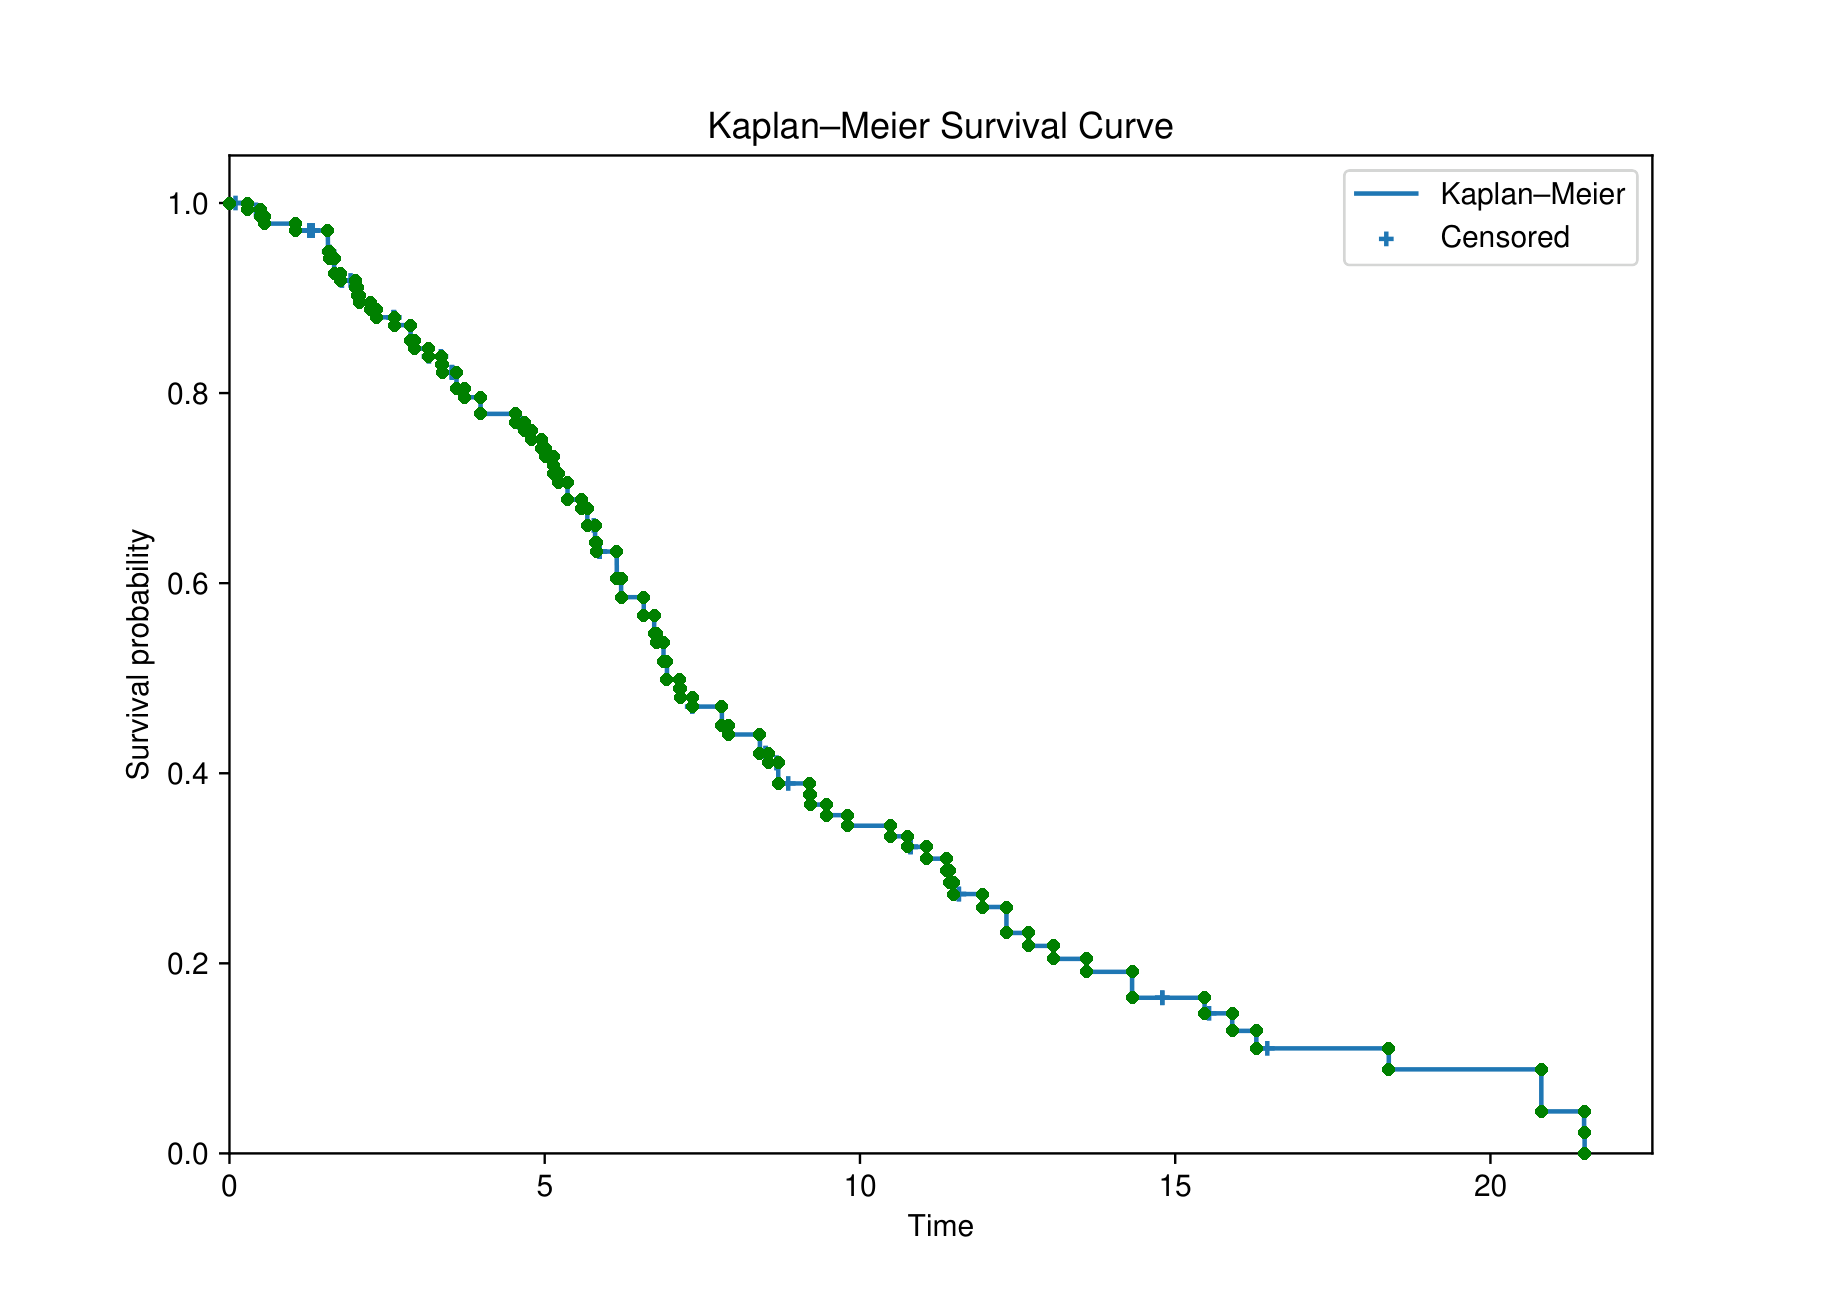

In [35]:
all_coords = longest_chain

zoom = 3  # 3x zoom gives roughly 216 DPI
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
# Overlay dots for all extracted points
for coords in all_coords:
    # print(f"Overlaying dot for coordinates: {coords}")
    img = overlay_dot_on_pdf(page, coords, img=img, dot_radius=2, zoom=zoom, dot_color = 'green')

img

## Axis Detection

In [36]:
line = line_list[0] # Set the line to the first extracted line

x_length = np.max([coord[0] for coord in line]) - np.min([coord[0] for coord in line])
y_length = np.max([coord[1] for coord in line]) - np.min([coord[1] for coord in line])

# Extract Non Curve Points
non_curve_coords = []
for d in drawings:
    all_coords = []
    if len(d['items']) > 60:
        continue

    for item in d["items"]:
        if item[0] != 'l':
            continue
        coord1 = item[1]
        coord2 = item[2]
        non_curve_coords.append(coord1)
        non_curve_coords.append(coord2)

### Extract Y axis

In [37]:
# Group non-curve points by x-value (rounded by default)
import numpy as np
from collections import defaultdict

points = non_curve_coords  # list of (x,y) tuples
if len(points) == 0:
    grouped_by_x = {}
else:
    pts_arr = np.array(points, dtype=float)

    def group_by_x(points, round_decimals=2, tol=None):
        """Group points by x-value.

        - If `round_decimals` is provided, x keys are rounded to that many decimals.
        - If `tol` is provided, points are clustered by x using that tolerance instead.
        """
        groups = defaultdict(list)
        if tol is not None:
            # cluster sorted by x using tolerance
            pts_sorted = sorted(points, key=lambda p: p[0])
            cluster = [pts_sorted[0]]
            for p in pts_sorted[1:]:
                if abs(p[0] - cluster[-1][0]) <= tol:
                    cluster.append(p)
                else:
                    key = round(float(np.mean([c[0] for c in cluster])), round_decimals)
                    groups[key].extend([(float(c[0]), float(c[1])) for c in cluster])
                    cluster = [p]
            # final cluster
            key = round(float(np.mean([c[0] for c in cluster])), round_decimals)
            groups[key].extend([(float(c[0]), float(c[1])) for c in cluster])
        else:
            for x, y in points:
                key = round(float(x), round_decimals)
                groups[key].append((float(x), float(y)))
        return dict(groups)

    # By default round x to 2 decimal places; change round_decimals or set tol as needed
    grouped_by_x = group_by_x(pts_arr, round_decimals=2)

    # Sort groups by key and convert lists to numpy arrays for easier downstream processing
    grouped_by_x = {k: np.array(v) for k, v in sorted(grouped_by_x.items(), key=lambda kv: kv[0])}

# Now compute absolute y-differences per group and compare with ±20% of y_length
# Try to use y_length from the notebook; fallback to computing from the first extracted line
if 'grouped_by_x' not in globals() or len(grouped_by_x) == 0:
    print("No groups to analyze (grouped_by_x is empty)")
else:
    # Ensure y_length is available
    if 'y_length' not in globals():
        if 'line_list' in globals() and len(line_list) > 0:
            line = line_list[0]
            y_length = np.max([coord[1] for coord in line]) - np.min([coord[1] for coord in line])
            print(f"Computed y_length from line_list[0]: {y_length:.3f}")
        else:
            raise NameError("y_length not found and cannot be computed; run the cell that computes x_length,y_length first")

    frac = 0.2
    threshold_min = y_length * (1 - frac)
    threshold_max = y_length * (1 + frac)

    grouped_summary = {}
    for k, v in grouped_by_x.items():
        ys = v[:, 1]
        y_diff = float(np.max(ys) - np.min(ys))
        in_threshold = (y_diff >= threshold_min) and (y_diff <= threshold_max)
        grouped_summary[k] = {
            'y_diff': y_diff,
            'count': int(len(v)),
            'in_threshold': bool(in_threshold),
            'threshold_min': float(threshold_min),
            'threshold_max': float(threshold_max)
        }


# expose convenience collections
groups_within_threshold_y = {k: grouped_by_x[k] for k, s in grouped_summary.items() if s['in_threshold']}

y_axis_list = []
for k in groups_within_threshold_y:
    v = groups_within_threshold_y[k]
    v = v.tolist()
    y_axis_list.append(v)

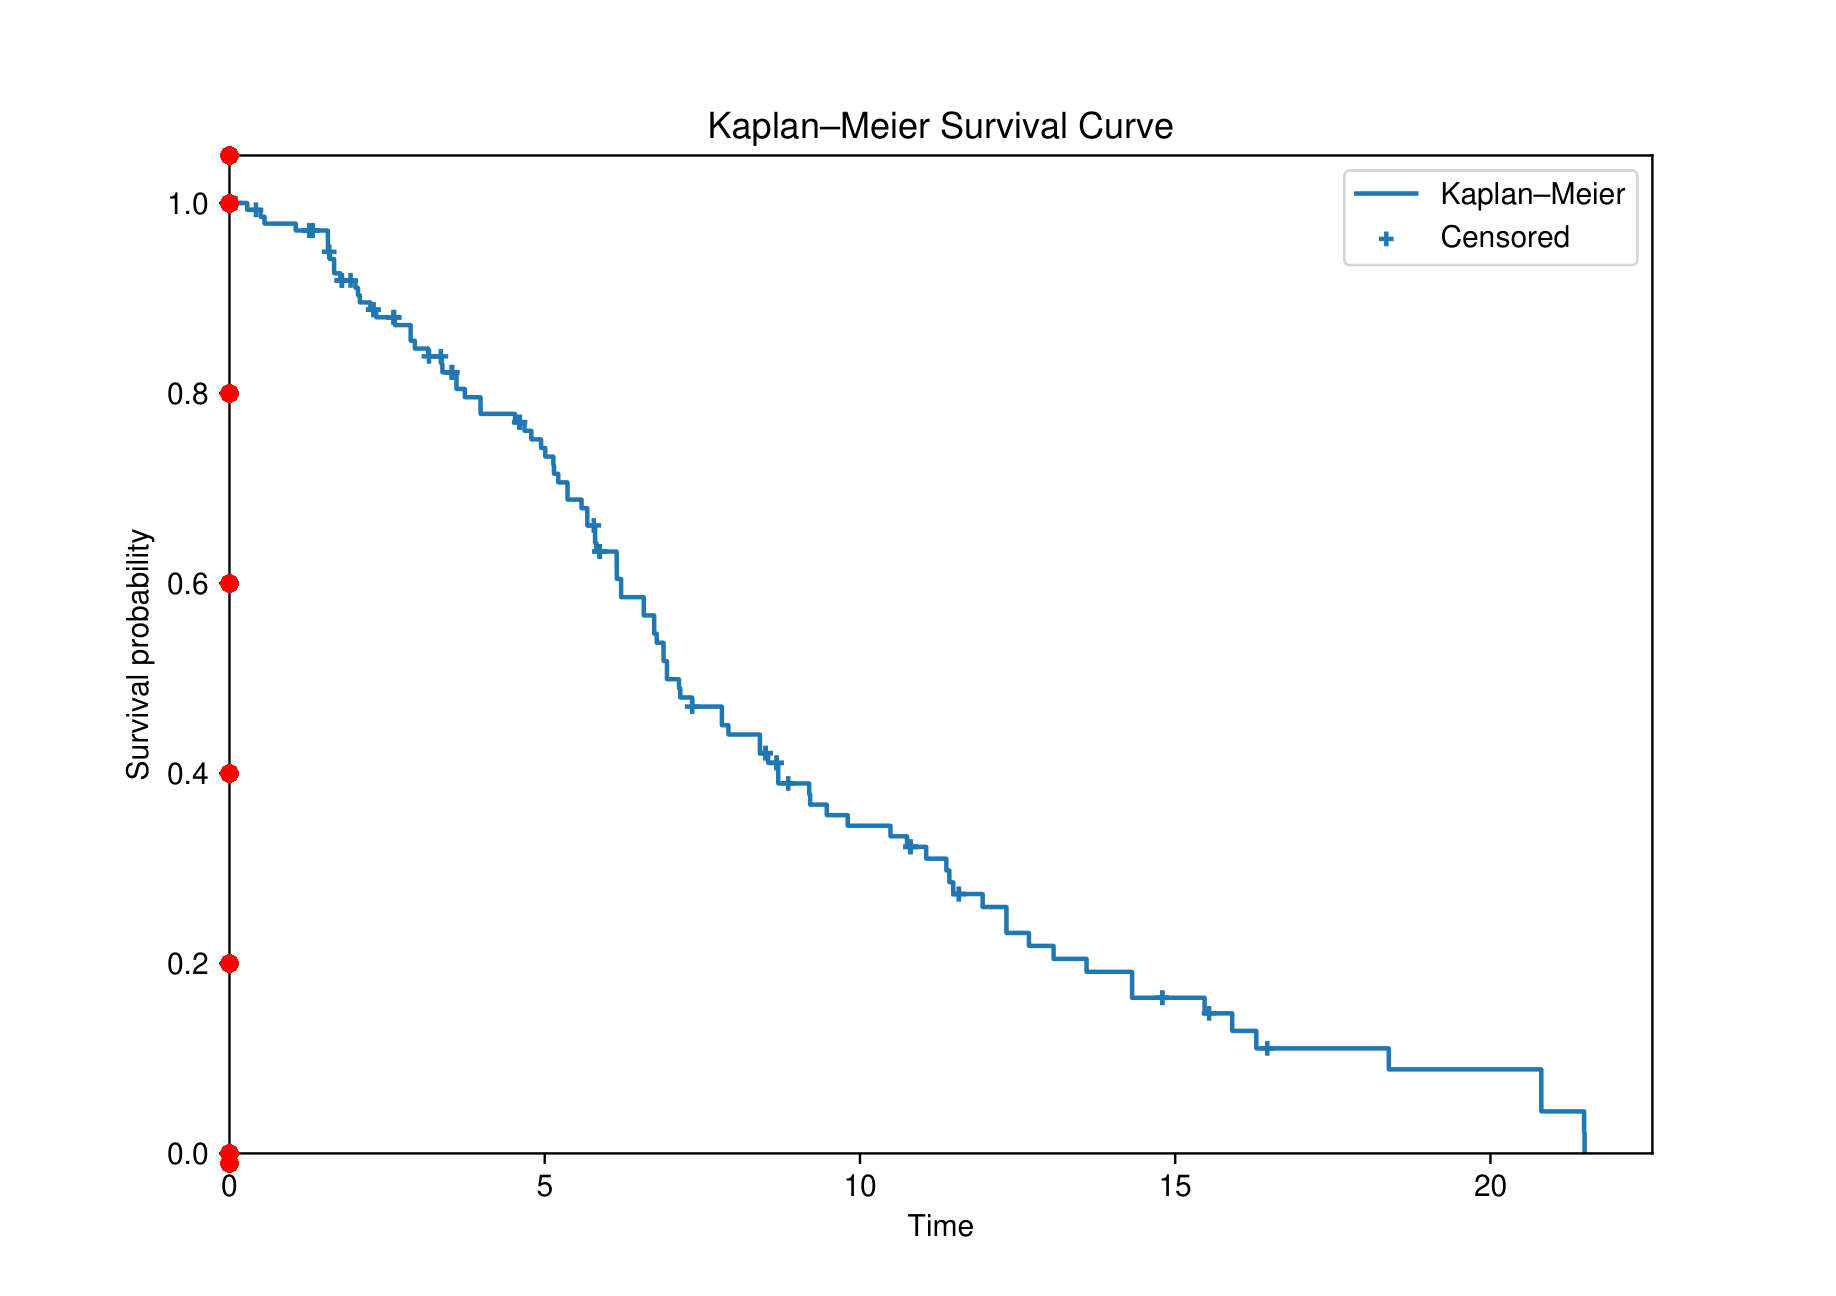

In [40]:
zoom = 3  # 3x zoom gives roughly 216 DPI
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

all_coords = y_axis_list[1]
# Overlay dots for all extracted points
for coords in all_coords:
    # print(f"Overlaying dot for coordinates: {coords}")
    img = overlay_dot_on_pdf(page, coords, img=img, dot_radius=3, zoom=zoom)
img

### Extract X axis

In [41]:
# Group non-curve points by y-value (rounded by default)
import numpy as np
from collections import defaultdict

points = non_curve_coords  # list of (x,y) tuples
if len(points) == 0:
    grouped_by_y = {}
else:
    pts_arr = np.array(points, dtype=float)

    def group_by_y(points, round_decimals=2, tol=None):
        """Group points by y-value.

        - If `round_decimals` is provided, y keys are rounded to that many decimals.
        - If `tol` is provided, points are clustered by y using that tolerance instead.
        """
        groups = defaultdict(list)
        if tol is not None:
            # cluster sorted by y using tolerance
            pts_sorted = sorted(points, key=lambda p: p[1])
            cluster = [pts_sorted[0]]
            for p in pts_sorted[1:]:
                if abs(p[1] - cluster[-1][1]) <= tol:
                    cluster.append(p)
                else:
                    key = round(float(np.mean([c[1] for c in cluster])), round_decimals)
                    groups[key].extend([(float(c[0]), float(c[1])) for c in cluster])
                    cluster = [p]
            # final cluster
            key = round(float(np.mean([c[1] for c in cluster])), round_decimals)
            groups[key].extend([(float(c[0]), float(c[1])) for c in cluster])
        else:
            for x, y in points:
                key = round(float(y), round_decimals)
                groups[key].append((float(x), float(y)))
        return dict(groups)

    # By default round y to 2 decimal places; change round_decimals or set tol as needed
    grouped_by_y = group_by_y(pts_arr, round_decimals=2)

    # Sort groups by key and convert lists to numpy arrays for easier downstream processing
    grouped_by_y = {k: np.array(v) for k, v in sorted(grouped_by_y.items(), key=lambda kv: kv[0])}

# Now compute absolute x-differences per group and compare with ±20% of x_length
# Try to use x_length from the notebook; fallback to computing from the first extracted line
if 'grouped_by_y' not in globals() or len(grouped_by_y) == 0:
    print("No groups to analyze (grouped_by_y is empty)")
else:
    # Ensure x_length is available
    if 'x_length' not in globals():
        if 'line_list' in globals() and len(line_list) > 0:
            line = line_list[0]
            x_length = np.max([coord[0] for coord in line]) - np.min([coord[0] for coord in line])
            print(f"Computed x_length from line_list[0]: {x_length:.3f}")
        else:
            raise NameError("x_length not found and cannot be computed; run the cell that computes x_length,y_length first")

    frac = 0.2
    threshold_min = x_length * (1 - frac)
    threshold_max = x_length * (1 + frac)

    grouped_summary_y = {}
    for k, v in grouped_by_y.items():
        xs = v[:, 0]
        x_diff = float(np.max(xs) - np.min(xs))
        in_threshold = (x_diff >= threshold_min) and (x_diff <= threshold_max)
        grouped_summary_y[k] = {
            'x_diff': x_diff,
            'count': int(len(v)),
            'in_threshold': bool(in_threshold),
            'threshold_min': float(threshold_min),
            'threshold_max': float(threshold_max)
        }

# expose convenience collections
groups_within_threshold_x = {k: grouped_by_y[k] for k, s in grouped_summary_y.items() if s['in_threshold']}

x_axis_list = []
for k in groups_within_threshold_x:
    v = groups_within_threshold_x[k]
    v = v.tolist()
    x_axis_list.append(v)

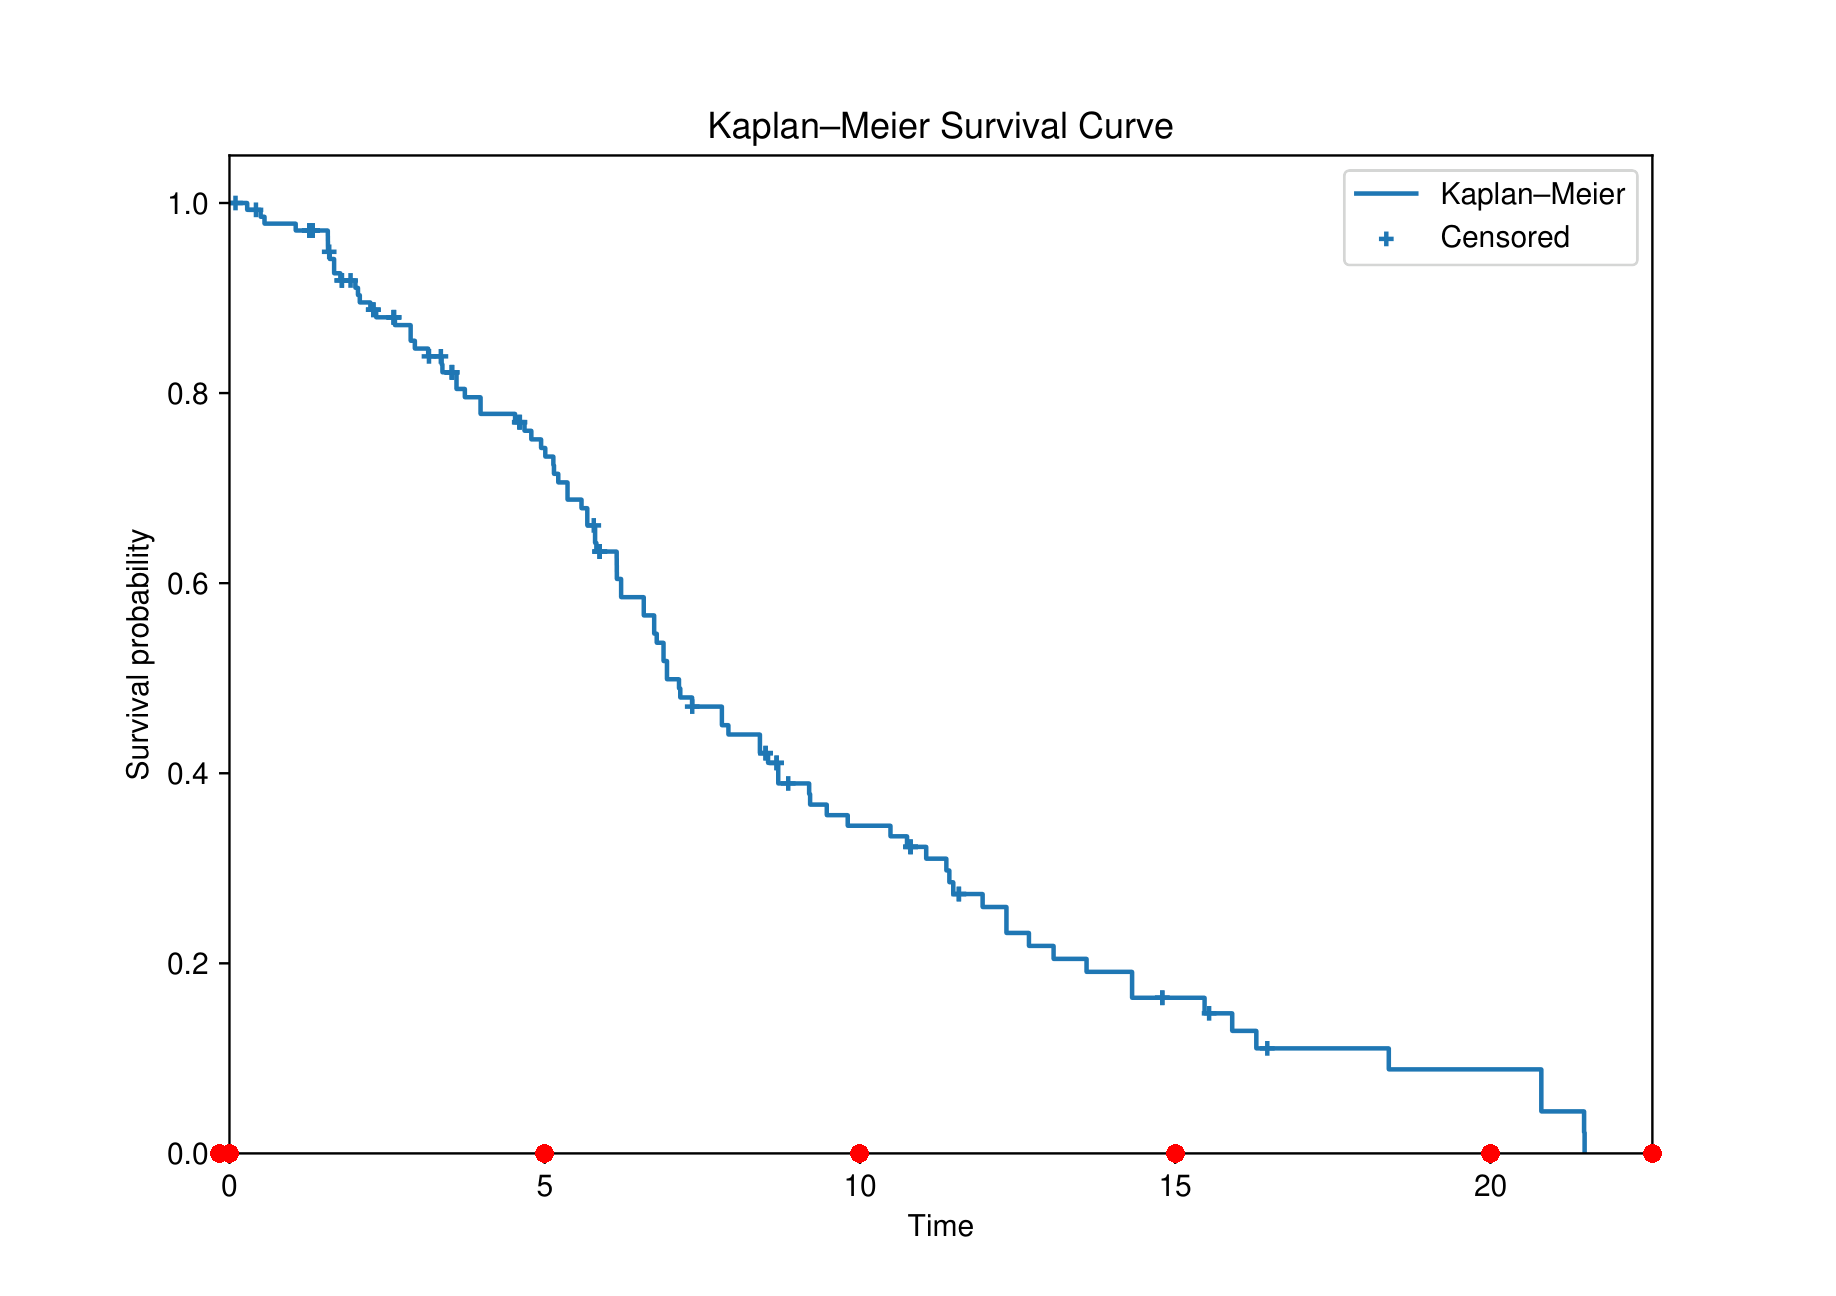

In [42]:
zoom = 3  # 3x zoom gives roughly 216 DPI
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

all_coords = x_axis_list[1]
# Overlay dots for all extracted points
for coords in all_coords:
    # print(f"Overlaying dot for coordinates: {coords}")
    img = overlay_dot_on_pdf(page, coords, img=img, dot_radius=3, zoom=zoom)
img

## Censor Detection

In [75]:
pdf_path = f"simulated_km_plot_{seed}.pdf"

import fitz

doc = fitz.open(pdf_path)
page = doc[1]

# Extract vector drawings (paths)
drawings = page.get_drawings()

all_coords = []
line_seg_list = []
for d in drawings:
    line_seg = []
    if len(d['items']) > 10:
        continue

    for item in d["items"]:
        if item[0]!="l":
            continue
        coord1 = item[1]
        coord2 = item[2]
        all_coords.append(coord1)
        all_coords.append(coord2)
        if coord1[0] == coord2[0]:
            line_seg.append(coord1)
            line_seg.append(coord2)
    line_seg_list.append(line_seg)
len(all_coords), len(line_seg_list)

(226, 65)

In [93]:
line_seg_list = np.array([d for d in line_seg_list if (len(d) > 0) & (len(d) < 4)])
start_coord_list = np.array([d[1] for d in line_seg_list])
length_list = np.array([np.abs(d[1][1] - d[0][1]) for d in line_seg_list])


target_coords = start_coord_list
target_seg_list = line_seg_list
target_length_list = length_list
print(f"Total points in full page: {len(start_coord_list)}")
print(f"Points inside plot region: {len(target_coords)}")

Total points in full page: 53
Points inside plot region: 53


In [94]:
import numpy as np

def _to_xy_array(seq):
    xs, ys = [], []
    for p in seq:
        if hasattr(p, "x") and hasattr(p, "y"):
            xs.append(float(p.x)); ys.append(float(p.y))
        else:
            xs.append(float(p[0])); ys.append(float(p[1]))
    return np.column_stack([xs, ys])

def min_dist_to_polyline(
    non_curve_coords,
    line_points,
    lower_threshold=None,
    upper_threshold=None,
    return_indices=False,
    return_proj=False,
):
    """
    True Euclidean distance from each point to the polyline defined by line_points.
    Works even when the closest location lies in the middle of a segment.
    """
    A = _to_xy_array(non_curve_coords)          # (N,2)
    P = _to_xy_array(line_points)               # (M,2)

    # segments: S_k = P[k] -> P[k+1]
    S0 = P[:-1]                                 # (M-1,2)
    S1 = P[1:]                                  # (M-1,2)
    V  = S1 - S0                                # (M-1,2)
    VV = (V**2).sum(axis=1)                     # (M-1,)

    # For each A_i, compute projection onto each segment
    # w = A_i - S0_k
    w = A[:, None, :] - S0[None, :, :]          # (N, M-1, 2)
    # t = clamp( dot(w,V) / |V|^2 , 0..1 )
    t = np.clip((w * V[None, :, :]).sum(axis=2) / np.maximum(VV, 1e-12), 0.0, 1.0)  # (N,M-1)
    proj = S0[None, :, :] + t[..., None] * V[None, :, :]                           # (N,M-1,2)

    # distances to each segment projection
    dists = np.linalg.norm(A[:, None, :] - proj, axis=2)   # (N, M-1)
    seg_idx = np.argmin(dists, axis=1)                     # (N,)
    min_dist = dists[np.arange(dists.shape[0]), seg_idx]   # (N,)
    
    # Thresholds
    if lower_threshold is None: lower_threshold = -np.inf
    if upper_threshold is None: upper_threshold =  np.inf
    mask = (min_dist >= lower_threshold) & (min_dist <= upper_threshold)

    filtered_points = [p for p, keep in zip(non_curve_coords, mask) if keep]
    filtered_dists  = min_dist[mask]
    nearest_idx     = seg_idx[mask]    # nearest segment index (S0->S1)

    if return_indices and return_proj:
        proj_pts = proj[np.arange(proj.shape[0])[mask], nearest_idx]
        return filtered_points, filtered_dists, nearest_idx, proj_pts
    if return_indices:
        return filtered_points, filtered_dists, mask
    return filtered_points, filtered_dists

In [114]:
# Filter by distance to polyline
candidate_points, dists, idx_mask = min_dist_to_polyline(
    non_curve_coords=target_coords,
    line_points=line,
    lower_threshold=0.0,   # exclude curve itself
    upper_threshold=5,
    return_indices=True   # exclude far objects
)

candidate_segs = target_seg_list[idx_mask]
candidate_lengths = target_length_list[idx_mask]

# Filter by segment length
candidate_poinsts = [p for p, l in zip(candidate_points, candidate_lengths) if np.abs(l - 4.89898682) < 0.01]

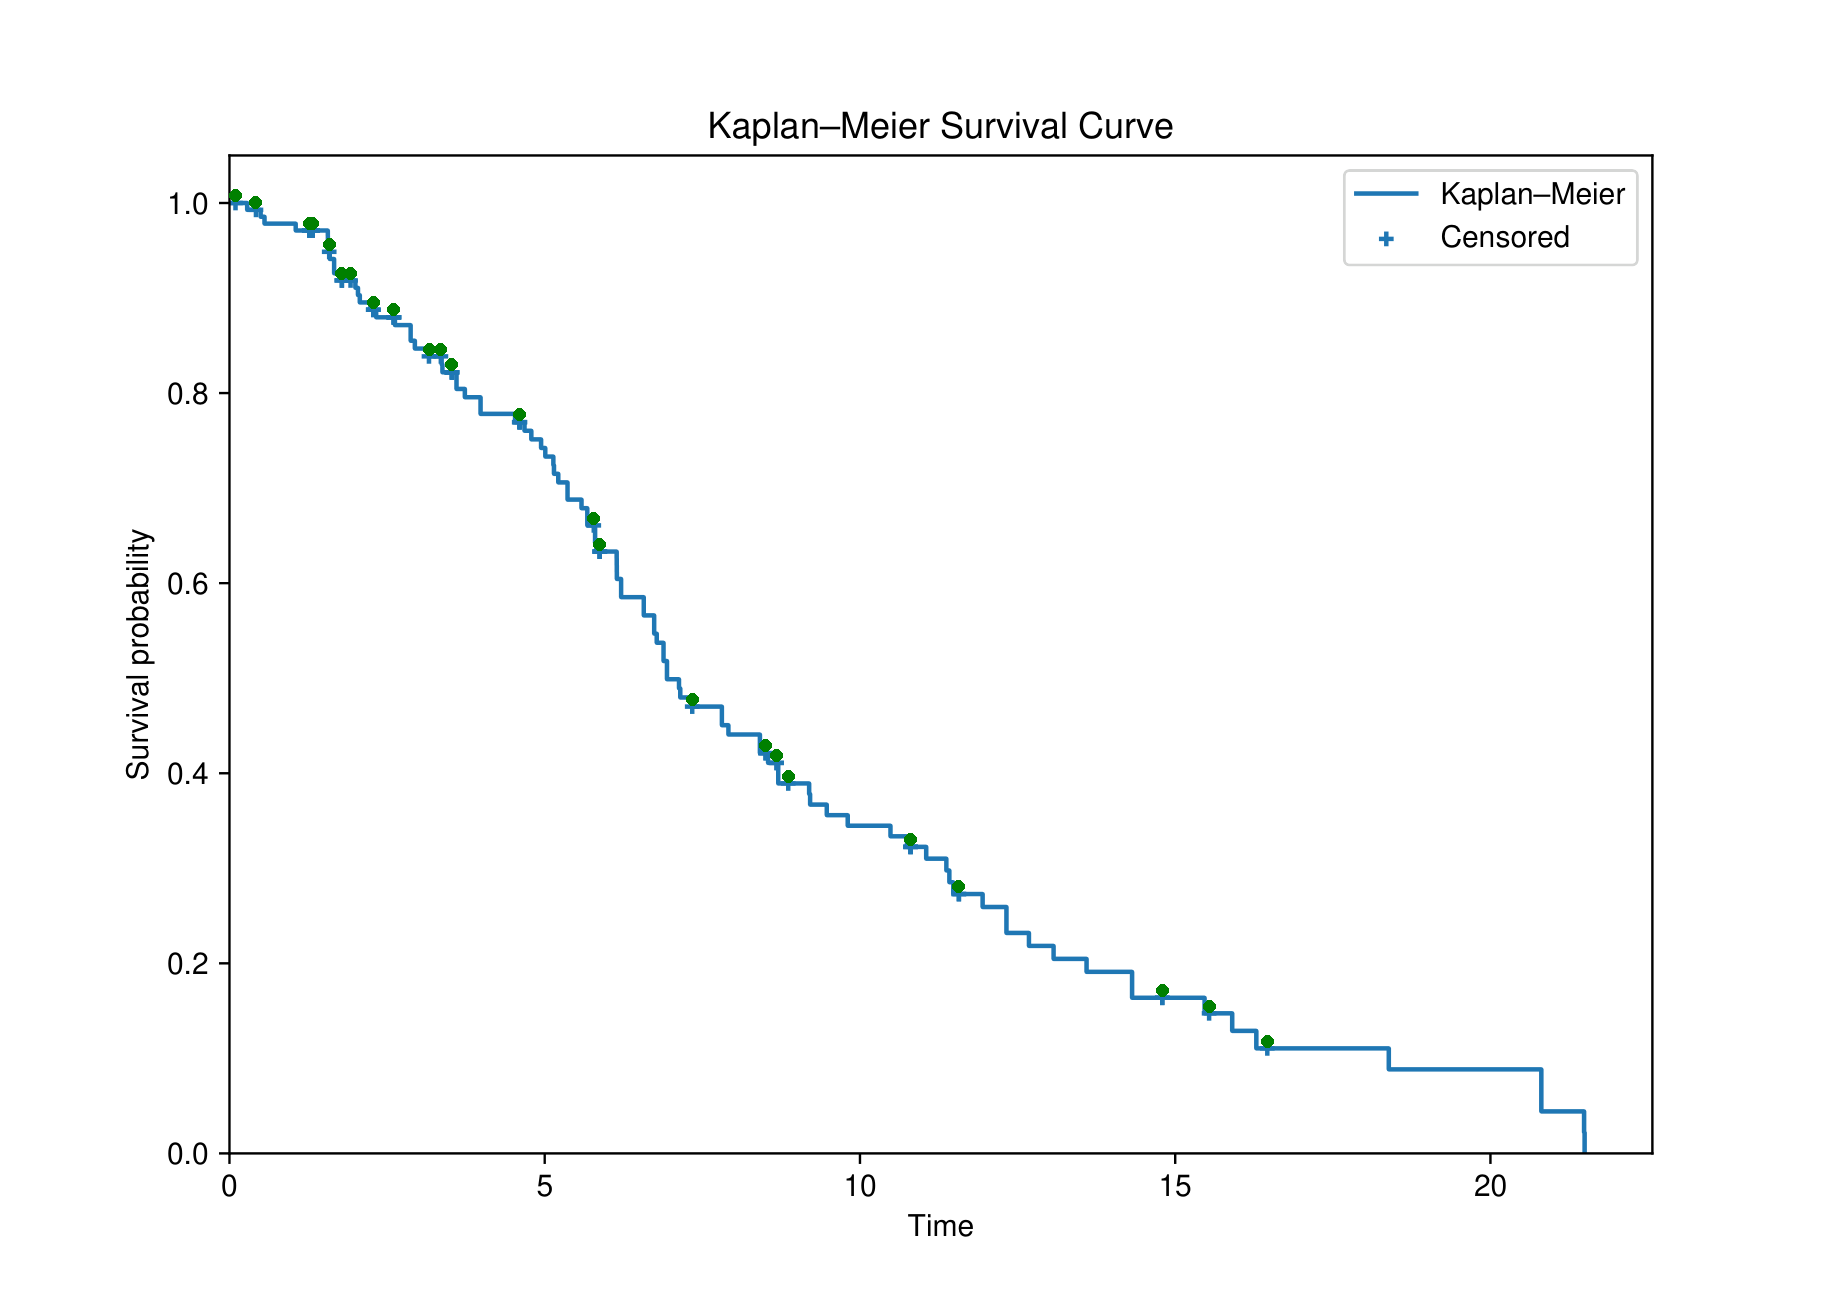

In [116]:
zoom = 3  # 3x zoom gives roughly 216 DPI
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

for points in candidate_points:
    img = overlay_dot_on_pdf(page, points, dot_radius=2, dot_color="green", img=img)
img